# Discretization Classification 2.0(Template) - KFold
## Author: Ming

In [32]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.calibration import CalibratedClassifierCV

#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock
lock = Lock()

#Import Our Class
%run "TEJ Classification Package.ipynb"

## Import Data

In [33]:
# Load Data
data_name = "Bankruptcy"
# data_name = "Australian_Original"

if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()
elif  data_name == "Australian_(Dis5Column)Without12":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Different_Continuous_Column()
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData()
elif  data_name == "Bankruptcy":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Bankruptcy_Data() 
elif  data_name == "TEJCN":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_TEJCN_Data() 
elif  data_name == "PAKDD":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_PAKDD_Data() 
    
# # Select Data
# data_list = tsaiData_data
# target_list = tsaiData_target
# discretize_coloumn = continuous_coloumn

# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values


# Declare Result List (Alogorithm, fold, ACC, AUC)
evaluation_result_list = []

In [34]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 1321
特徵數量(不含Target) :: 16


In [35]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts))

{1: 697, 2: 624}

## Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [36]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## KFoldFuntion

In [37]:
class KFoldFuntion:
    # linear_svc,'linear_svc','baseline', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, method, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.method = method  # (Baseline, MDLP, CAIM)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        #for train_index, test_index in kf.split(self.X,self.y):
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            if self.method == 'Baseline':
                
                # Convert to Dataframe
                X_train_dataframe = pd.DataFrame(X_train)
                X_test_dataframe  = pd.DataFrame(X_test)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe  = pd.DataFrame(y_test)
                predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
            else:

                # Declare Training Data Discretizer
                discretize_train = Discretization(X_train,y_train,self.discretize_coloumn)

                # Select Discretize Feature (Training Data Continous Feature)
                selectData_list, disSelectData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns

                
                
                # Discretize(Train)
                if self.method == 'MDLP':
                    selectDataDiscretiz_list = discretize_train.MDLP(selectData_list)
                elif self.method == 'CAIMD':
                    selectDataDiscretiz_list = discretize_train.CAIMD(selectData_list)
                elif self.method == 'ChiMerge_SC':
                    selectDataDiscretiz_list = discretize_train.ChiMerge_SC(selectData_list)
                elif self.method == 'ChiMerge_RG':
                    selectDataDiscretiz_list = discretize_train.ChiMerge_RG(selectData_list)
                # Merge dis_feature & categeorial_feature
                X_train_dis = discretize_train.MergeFeatures(selectDataDiscretiz_list,disSelectData_list)

                # Declare Testing Data Discretizer
                discretize_test = Discretization(X_test,y_test,discretize_coloumn)

                # Select Discretize Feature (Testing Data Continous Feature)
                selectData_test_list, disSelectData_test_list  = discretize_test.SelectFeatures()

                
                
                # Employ Training Data Cutpoint
                if self.method == 'MDLP':
                    selectDataDiscretiz_test_list = discretize_train.MDLP_transform(selectData_test_list)
                elif self.method == 'CAIMD':
                    selectDataDiscretiz_test_list = discretize_train.CAIMD_transform(selectData_test_list)
                elif self.method == 'ChiMerge_SC':
                    selectDataDiscretiz_test_list = discretize_train.ChiMerge_SC_transform(selectData_test_list)
                elif self.method == 'ChiMerge_RG':
                    selectDataDiscretiz_test_list = discretize_train.ChiMerge_RG_transform(selectData_test_list)
                    
                # Merge dis_feature & categeorial_feature
                X_test_dis = discretize_test.MergeFeatures(selectDataDiscretiz_test_list,disSelectData_test_list)

                # Convert to Dataframe
                X_train_dis_dataframe = pd.DataFrame(X_train_dis)
                X_test_dis_dataframe = pd.DataFrame(X_test_dis)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe = pd.DataFrame(y_test)

                # Prediction
                predictions,proba = self.Classification(X_train_dis_dataframe,y_train_dataframe,X_test_dis_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe[0].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{method}-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,method=self.method,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [38]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC):
    #Labels
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_SC')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    #autolabel(rects5)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [39]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [40]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

## Start Classify

## Run 10 Times

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarn


程式開始
Mean Accuracy: 0.6532847341337907
Mean Accuracy[0.6641509433962264, 0.6628787878787878, 0.6174242424242424, 0.6174242424242424, 0.7045454545454546]
Mean Auc: 0.7071849079535856
Mean Auc[0.7172649572649573, 0.725423336993585, 0.6431446974925236, 0.7061478051925218, 0.7439437428243398]
Mean TypeII: 0.025890309197426065
Mean TypeII[0.038461538461538464, 0.024793388429752067, 0.015873015873015872, 0.035398230088495575, 0.014925373134328358]
Mean TypeI: 0.6336023237088598
Mean TypeI[0.6222222222222222, 0.6013986013986014, 0.717391304347826, 0.6423841059602649, 0.5846153846153846]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.9023613493424815
Mean Accuracy[0.8830188679245283, 0.9015151515151515, 0.8787878787878788, 0.9128787878787878, 0.9356060606060606]
Mean Auc: 0.9024260921160654
Mean Auc[0.8841428571428571, 0.9011651265568502, 0.8772374100719423, 0.9109328099746017, 0.9386522568340749]
Mean TypeII: 0.10651713094586783
Mean TypeII[0.096, 0.1450381679389313, 0.152, 0.11475409836065574, 0.024793388429752067]
Mean TypeI: 0.0886306848220016
Mean TypeI[0.1357142857142857, 0.05263157894736842, 0.09352517985611511, 0.06338028169014084, 0.0979020979020979]
Mean Accuracy: 0.798650657518582
Mean Accuracy[0.7811320754716982, 0.803030303030303, 0.803030303030303, 0.7803030303030303, 0.8257575757575758]
Mean Auc: 0.8654615502793568
Mean Auc[0.8286625655046708, 0.8811510791366906, 0.8624451627799584, 0.87369398653355, 0.8813549574419139]
Mean TypeII: 0.11697375029683126
Mean TypeII[0.11278195488721804, 0.112, 0.13934426229508196, 0.1016949152542373, 0.11904761904761904]
Mean TypeI: 0.27706478365422926

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


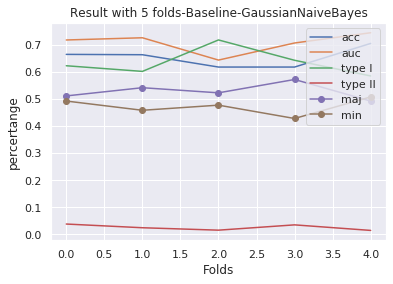

Mean : [0.65328473 0.70718491 0.63360232 0.02589031]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 

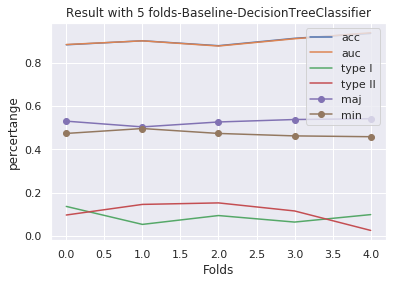

Mean : [0.90236135 0.90242609 0.08863068 0.10651713]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


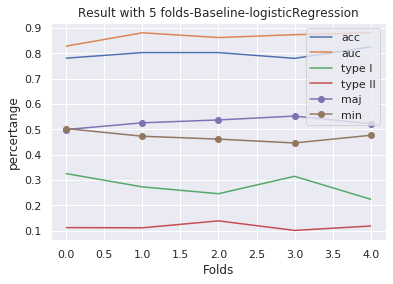

Mean : [0.79865066 0.86546155 0.27706478 0.11697375]
Mean Accuracy: 0.9190194396798169
Mean Accuracy[0.8943396226415095, 0.9393939393939394, 0.928030303030303, 0.9242424242424242, 0.9090909090909091]
Mean Auc: 0.9729584724734599
Mean Auc[0.9675369288904156, 0.9813606710158435, 0.9687427443696308, 0.9855251798561151, 0.9616268382352942]
Mean TypeII: 0.10071961845784738
Mean TypeII[0.13008130081300814, 0.06896551724137931, 0.09322033898305085, 0.08633093525179857, 0.125]
Mean TypeI: 0.06323582925345703
Mean TypeI[0.08450704225352113, 0.05405405405405406, 0.0547945205479452, 0.064, 0.058823529411764705]
Mean Accuracy: 0.9137164093767867
Mean Accuracy[0.8943396226415095, 0.9015151515151515, 0.9356060606060606, 0.9318181818181818, 0.9053030303030303]
Mean Auc: 0.9735080246183406
Mean Auc[0.961542850621933, 0.9672073957788243, 0.9879629629629629, 0.9889705882352942, 0.9618563254926892]
Mean TypeII: 0.07578837842548317
Mean TypeII[0.11594202898550725, 0.06837606837606838, 0.041666666666666664

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.

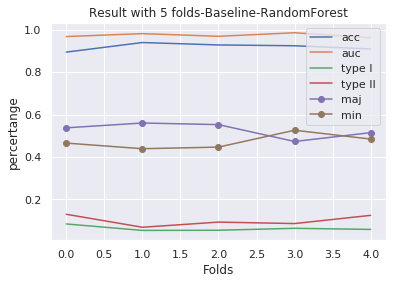

Mean : [0.91901944 0.97295847 0.06323583 0.10071962]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Accuracy: 0.685071469411092
Mean Accuracy[0.7056603773584905, 0.6818181818181818, 0.6666666666666666, 0.6742424242424242, 0.696969696969697]
Mean Auc: 0.8391384427396857
Mean Auc[0.8745408631772268, 0.8273041474654378, 0.8225212790430181, 0.8495666647534867, 0.8217592592592592]
Mean TypeII: 0.6380115667289614
Mean TypeII[0.628099173553719, 0.6612903225806451, 0.6507936507936508, 0.6165413533834586, 0.6333333333333333]
Mean TypeI: 0.025992998593396866
Mean TypeI[0.013888888888888888, 0.014285714285714285, 0.043478260869565216, 0.030534351145038167, 0.027777777777777776]


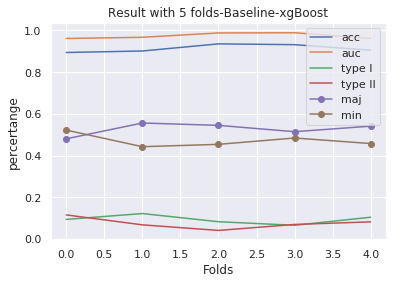

Mean : [0.91371641 0.97350802 0.09426842 0.07578838]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calib

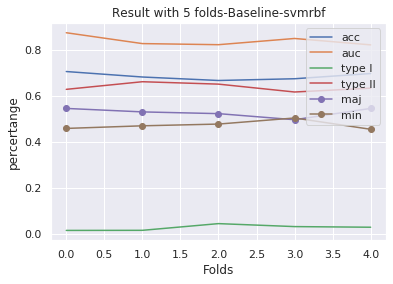

Mean : [0.68507147 0.83913844 0.025993   0.63801157]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calib

Mean Accuracy: 0.7941023441966838
Mean Accuracy[0.7849056603773585, 0.7954545454545454, 0.8295454545454546, 0.7916666666666666, 0.7689393939393939]
Mean Auc: 0.8636321388078366
Mean Auc[0.8722661170273676, 0.8611175115207373, 0.9310661764705882, 0.7876263786764706, 0.8660845103440192]
Mean TypeII: 0.10272226780952802
Mean TypeII[0.11382113821138211, 0.0967741935483871, 0.09375, 0.058823529411764705, 0.1504424778761062]
Mean TypeI: 0.30080843774176025
Mean TypeI[0.3028169014084507, 0.3, 0.2426470588235294, 0.3671875, 0.2913907284768212]


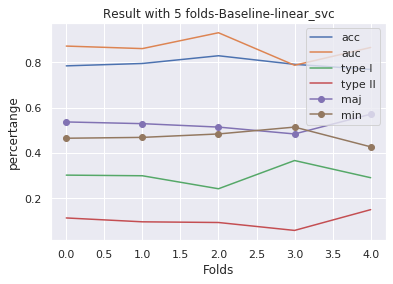

Mean : [0.79410234 0.86363214 0.30080844 0.10272227]
Mean Accuracy: 0.8213436249285306
Mean Accuracy[0.8264150943396227, 0.8181818181818182, 0.803030303030303, 0.7878787878787878, 0.8712121212121212]
Mean Auc: 0.8575037459272356
Mean Auc[0.8151837856406734, 0.8765144989951191, 0.8480224321133413, 0.8420688462203771, 0.9057291666666667]
Mean TypeII: 0.15024465533640835
Mean TypeII[0.1056338028169014, 0.17829457364341086, 0.16363636363636364, 0.18699186991869918, 0.11666666666666667]
Mean TypeI: 0.20618567367399748
Mean TypeI[0.25203252032520324, 0.18518518518518517, 0.22077922077922077, 0.23404255319148937, 0.1388888888888889]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


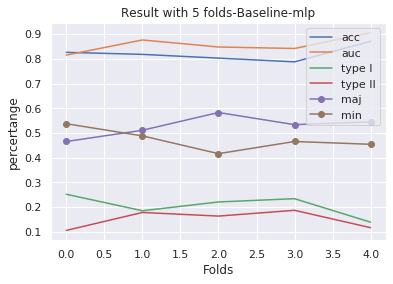

Mean : [0.82134362 0.85750375 0.20618567 0.15024466]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 

Mean Accuracy: 0.8470811892510006
Mean Accuracy[0.8528301886792453, 0.8522727272727273, 0.8143939393939394, 0.8977272727272727, 0.8181818181818182]
Mean Auc: 0.8983150404778846
Mean Auc[0.9156698564593302, 0.9136806860902256, 0.8662566814184723, 0.9301122158265015, 0.865855762594893]
Mean TypeII: 0.16324206004862937
Mean TypeII[0.14393939393939395, 0.15178571428571427, 0.24087591240875914, 0.13675213675213677, 0.14285714285714285]
Mean TypeI: 0.14266365404880127
Mean TypeI[0.15037593984962405, 0.14473684210526316, 0.12598425196850394, 0.07482993197278912, 0.21739130434782608]


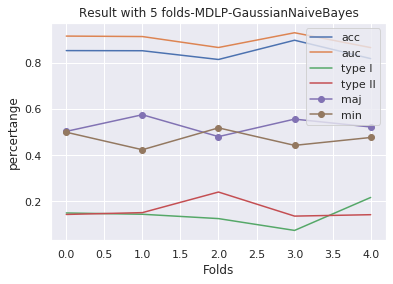

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.8841738136077758
Mean Accuracy[0.8905660377358491, 0.8598484848484849, 0.8863636363636364, 0.9015151515151515, 0.8825757575757576]
Mean Auc: 0.9359176600588203
Mean Auc[0.9326292160699896, 0.9418202764976958, 0.9513093525179855, 0.941044776119403, 0.9127846790890269]
Mean TypeII: 0.09946929402033766
Mean TypeII[0.06722689075630252, 0.1532258064516129, 0.104, 0.05384615384615385, 0.11904761904761904]
Mean TypeI: 0.13048845540895854
Mean TypeI[0.14383561643835616, 0.12857142857142856, 0.1223021582733813, 0.1417910447761194, 0.11594202898550725]
Mean Accuracy: 0.882652944539737
Mean Accuracy[0.8981132075471698, 0.8636363636363636, 0.8825757575757576, 0.8712121212121212, 0.8977272727272727]
Mean Auc: 0.8987966536367633
Mean Auc[0.9121935633786453, 0.8739380022962112, 0.91015625, 0.8999131944444444, 0.8977822580645161]
Mean TypeII: 0.11422067978294884
Mean TypeII[0.11403508771929824, 0.1, 0.11029411764705882, 0.15, 0.0967741935483871]
Mean TypeI: 0.12152219821736476
Mean Ty

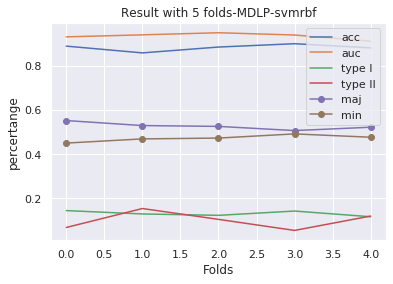

Categorical []
Mean Accuracy: 0.8872069754145226
Mean Accuracy[0.8867924528301887, 0.8939393939393939, 0.8446969696969697, 0.9015151515151515, 0.9090909090909091]
Mean Auc: 0.9448549746056921
Mean Auc[0.9456880838459786, 0.9275971223021583, 0.9312316799816082, 0.9623179041353384, 0.9574400827633773]
Mean TypeII: 0.0960633473447398
Mean TypeII[0.12781954887218044, 0.08, 0.09448818897637795, 0.10714285714285714, 0.07086614173228346]
Mean TypeI: 0.12825087954642395
Mean TypeI[0.09848484848484848, 0.12949640287769784, 0.2116788321167883, 0.09210526315789473, 0.10948905109489052]
Mean Accuracy: 0.8682818753573469
Mean Accuracy[0.8679245283018868, 0.8787878787878788, 0.8901515151515151, 0.8371212121212122, 0.8674242424242424]
Mean Auc: 0.924993011302416
Mean Auc[0.9328078078078078, 0.9360754985754985, 0.9295506912442396, 0.9020573746740075, 0.9244736842105263]
Mean TypeII: 0.11476166100485519
Mean TypeII[0.10256410256410256, 0.1111111111111111, 0.1, 0.1724137931034483, 0.08771929824561403]
M

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


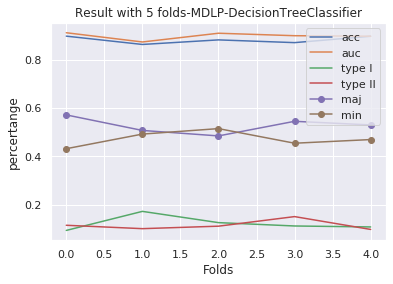

Categorical []


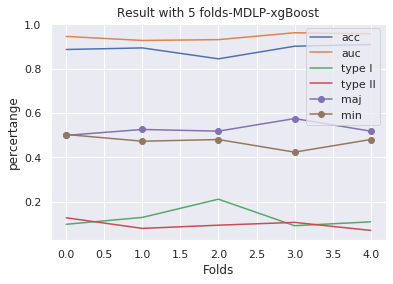

Mean Accuracy: 0.8849542595769011
Mean Accuracy[0.8603773584905661, 0.9015151515151515, 0.8674242424242424, 0.8977272727272727, 0.8977272727272727]
Mean Auc: 0.9415696505812845
Mean Auc[0.9393654591023012, 0.94912045666356, 0.9417293233082706, 0.9385295299316995, 0.9391034839005912]
Mean TypeII: 0.11629629018225048
Mean TypeII[0.14393939393939395, 0.08620689655172414, 0.11607142857142858, 0.09022556390977443, 0.1450381679389313]
Mean TypeI: 0.11256749776235513
Mean TypeI[0.13533834586466165, 0.10810810810810811, 0.14473684210526316, 0.11450381679389313, 0.06015037593984962]
Categorical []


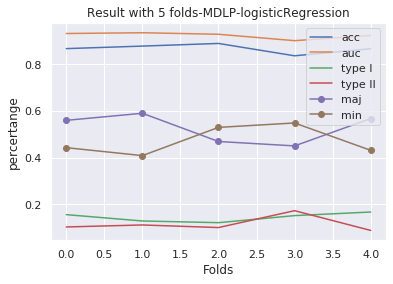

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


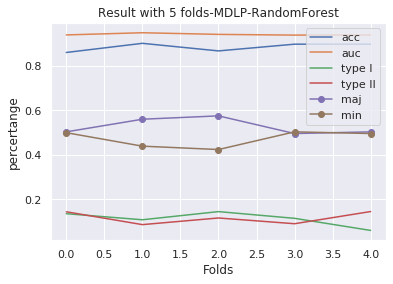

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Accuracy: 0.8698084619782733
Mean Accuracy[0.8528301886792453, 0.9015151515151515, 0.8674242424242424, 0.8598484848484849, 0.8674242424242424]
Mean Auc: 0.9150017546301663
Mean Auc[0.9016024178832116, 0.9412442396313364, 0.9014477585906158, 0.9273614699971289, 0.9033528870485392]
Mean TypeII: 0.11057347527129036
Mean TypeII[0.1328125, 0.07258064516129033, 0.1282051282051282, 0.12403100775193798, 0.09523809523809523]
Mean TypeI: 0.1480578314050681
Mean TypeI[0.16058394160583941, 0.12142857142857143, 0.1360544217687075, 0.15555555555555556, 0.16666666666666666]


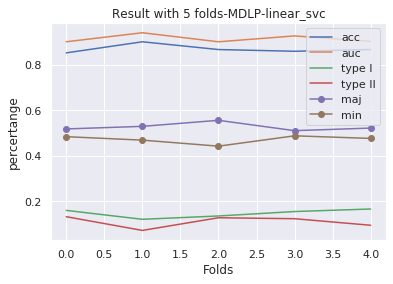

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.8781189251000573
Mean Accuracy[0.8830188679245283, 0.8674242424242424, 0.8977272727272727, 0.9128787878787878, 0.8295454545454546]
Mean Auc: 0.9434396134138764
Mean Auc[0.9447413793103449, 0.9385706018518518, 0.9573167197913649, 0.9676715475165087, 0.9088978185993112]
Mean TypeII: 0.10089456295338647
Mean TypeII[0.075, 0.11666666666666667, 0.10084033613445378, 0.08888888888888889, 0.12307692307692308]
Mean TypeI: 0.14053899508073106
Mean TypeI[0.15172413793103448, 0.14583333333333334, 0.10344827586206896, 0.08527131782945736, 0.21641791044776118]


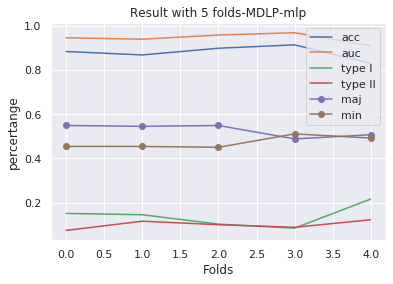

Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []
Categorical []
Categorical []
Categorical

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


 []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Categorical []
Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Categorical []
Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Accuracy: 0.8652401372212694
Mean Accuracy[0.8830188679245283, 0.875, 0.8409090909090909, 0.8901515151515151, 0.8371212121212122]
Mean Auc: 0.9239582778609563
Mean Auc[0.934911919469229, 0.9186568033550793, 0.9220070118972354, 0.9362156545832371, 0.908]
Mean TypeII: 0.15016659713776614
Mean TypeII[0.18548387096774194, 0.12931034482758622, 0.15328467153284672, 0.11475409836065574, 0.168]
Mean TypeI: 0.12152414501892614
Mean TypeI[0.05673758865248227, 0.12162162162162163, 0.16535433070866143, 0.1056338028169014, 0.15827338129496402]
Mean Accuracy: 0.8614808461978274
Mean Accuracy[0.8452830188679246, 0.8598484848484849, 0.8712121212121212, 0.8560606060606061, 0.875]
Mean Auc: 0.901090625893376
Mean Auc[0.8957621326042378, 0.9064460431654676, 0.9140211640211641, 0.8739842117483166, 0.9152395779276941]
Mean TypeII: 0.12987659098514823
Mean TypeII[0.10606060606060606, 0.168, 0.14285714285714285, 0.11864406779661017, 0.11382113821138211]
Mean TypeI: 0.1466385592290091
Mean TypeI[0.203007

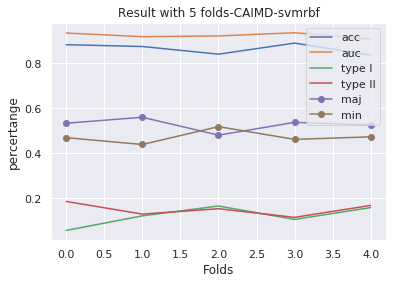

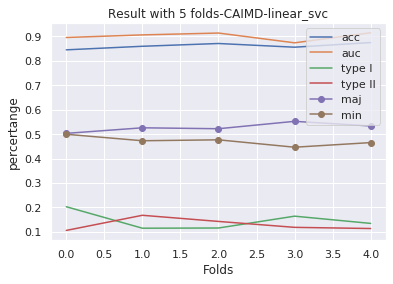

Mean Accuracy: 0.8448170383076044
Mean Accuracy[0.8415094339622642, 0.8143939393939394, 0.8484848484848485, 0.8560606060606061, 0.8636363636363636]
Mean Auc: 0.8765735140780857
Mean Auc[0.888, 0.8453282828282829, 0.8831975619762058, 0.8703129486075223, 0.8960287769784172]
Mean TypeII: 0.1514488353383599
Mean TypeII[0.136, 0.15151515151515152, 0.19469026548672566, 0.15503875968992248, 0.12]
Mean TypeI: 0.1603772332611248
Mean TypeI[0.17857142857142858, 0.2196969696969697, 0.11920529801324503, 0.13333333333333333, 0.1510791366906475]


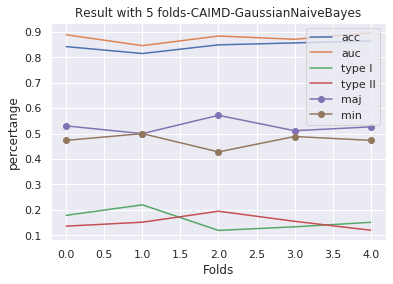

Mean Accuracy: 0.8819153802172671
Mean Accuracy[0.8716981132075472, 0.8787878787878788, 0.8977272727272727, 0.8787878787878788, 0.8825757575757576]
Mean Auc: 0.9301414282819078
Mean Auc[0.9362274079158087, 0.9389893769738731, 0.9242038952782754, 0.9123229626189924, 0.9389634986225895]
Mean TypeII: 0.13402226274456275
Mean TypeII[0.14516129032258066, 0.20155038759689922, 0.08264462809917356, 0.1271186440677966, 0.11363636363636363]
Mean TypeI: 0.10289024360140653
Mean TypeI[0.11347517730496454, 0.044444444444444446, 0.11888111888111888, 0.11643835616438356, 0.12121212121212122]


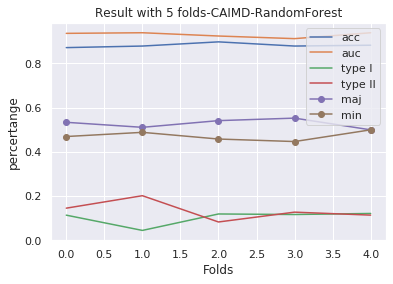

Mean Accuracy: 0.8690708976558034
Mean Accuracy[0.8264150943396227, 0.8825757575757576, 0.8787878787878788, 0.8712121212121212, 0.8863636363636364]
Mean Auc: 0.9282525299942691
Mean Auc[0.9061389430241888, 0.941397445529677, 0.9423900462962962, 0.9266735679779158, 0.9246626471432673]
Mean TypeII: 0.13516497384604687
Mean TypeII[0.13934426229508196, 0.08264462809917356, 0.175, 0.18253968253968253, 0.0962962962962963]
Mean TypeI: 0.1275064658406418
Mean TypeI[0.20279720279720279, 0.14685314685314685, 0.0763888888888889, 0.07971014492753623, 0.13178294573643412]


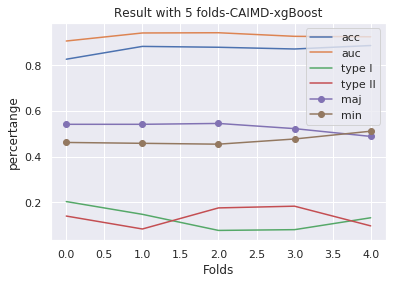

Mean Accuracy: 0.8698056032018296
Mean Accuracy[0.8566037735849057, 0.8674242424242424, 0.8863636363636364, 0.8712121212121212, 0.8674242424242424]
Mean Auc: 0.8991062178292779
Mean Auc[0.8833504624871531, 0.8929519741399214, 0.921875, 0.8953157650336662, 0.9020378874856487]
Mean TypeII: 0.13771285006671571
Mean TypeII[0.14285714285714285, 0.13114754098360656, 0.1328125, 0.13559322033898305, 0.14615384615384616]
Mean TypeI: 0.12319332011787212
Mean TypeI[0.14388489208633093, 0.13380281690140844, 0.09558823529411764, 0.1232876712328767, 0.11940298507462686]


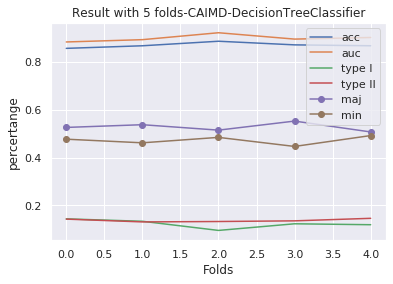

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.8629931389365352
Mean Accuracy[0.8490566037735849, 0.8636363636363636, 0.8522727272727273, 0.9053030303030303, 0.8446969696969697]
Mean Auc: 0.913845229228957
Mean Auc[0.9179117244525548, 0.928341384863124, 0.8996190256291849, 0.9344908082871316, 0.8888632029127898]
Mean TypeII: 0.1265293557538058
Mean TypeII[0.1328125, 0.11594202898550725, 0.12295081967213115, 0.09565217391304348, 0.1652892561983471]
Mean TypeI: 0.14728806666256083
Mean TypeI[0.1678832116788321, 0.15873015873015872, 0.16901408450704225, 0.09395973154362416, 0.14685314685314685]


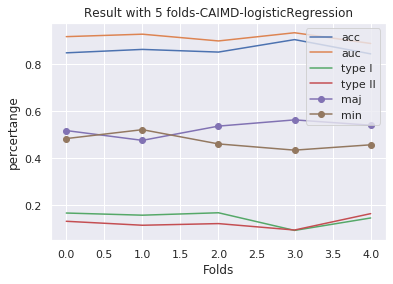

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.8652315608919382
Mean Accuracy[0.8943396226415095, 0.8787878787878788, 0.8371212121212122, 0.8560606060606061, 0.8598484848484849]
Mean Auc: 0.9200530971073683
Mean Auc[0.9466444111891332, 0.9174827188940091, 0.8880528166983799, 0.9207186322804984, 0.9273669064748201]
Mean TypeII: 0.14056641205293735
Mean TypeII[0.12605042016806722, 0.08064516129032258, 0.16260162601626016, 0.16806722689075632, 0.16546762589928057]
Mean TypeI: 0.1290884902887275
Mean TypeI[0.08904109589041095, 0.15714285714285714, 0.16312056737588654, 0.12413793103448276, 0.112]


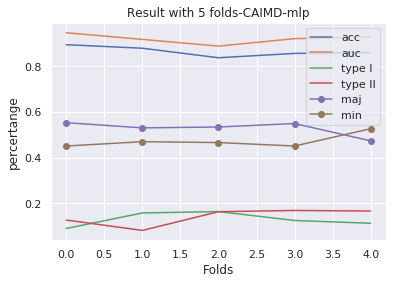

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, incre

Mean Accuracy: 0.8054688393367639
Mean Accuracy[0.7811320754716982, 0.8371212121212122, 0.7613636363636364, 0.8257575757575758, 0.821969696969697]
Mean Auc: 0.8798882561067002
Mean Auc[0.8671705026909424, 0.9058243987250073, 0.8276972624798712, 0.8969470046082951, 0.9018021120293848]
Mean TypeII: 0.17397618990852665
Mean TypeII[0.0975609756097561, 0.14285714285714285, 0.24603174603174602, 0.20161290322580644, 0.18181818181818182]
Mean TypeI: 0.2118760978025712
Mean TypeI[0.323943661971831, 0.1793103448275862, 0.2318840579710145, 0.15, 0.17424242424242425]


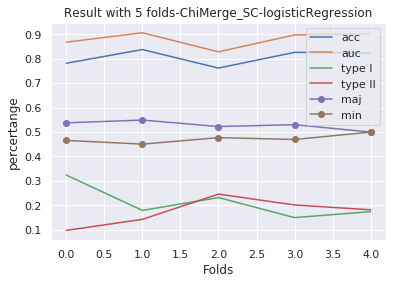

Compare Result-Bankruptcy-logisticRegression


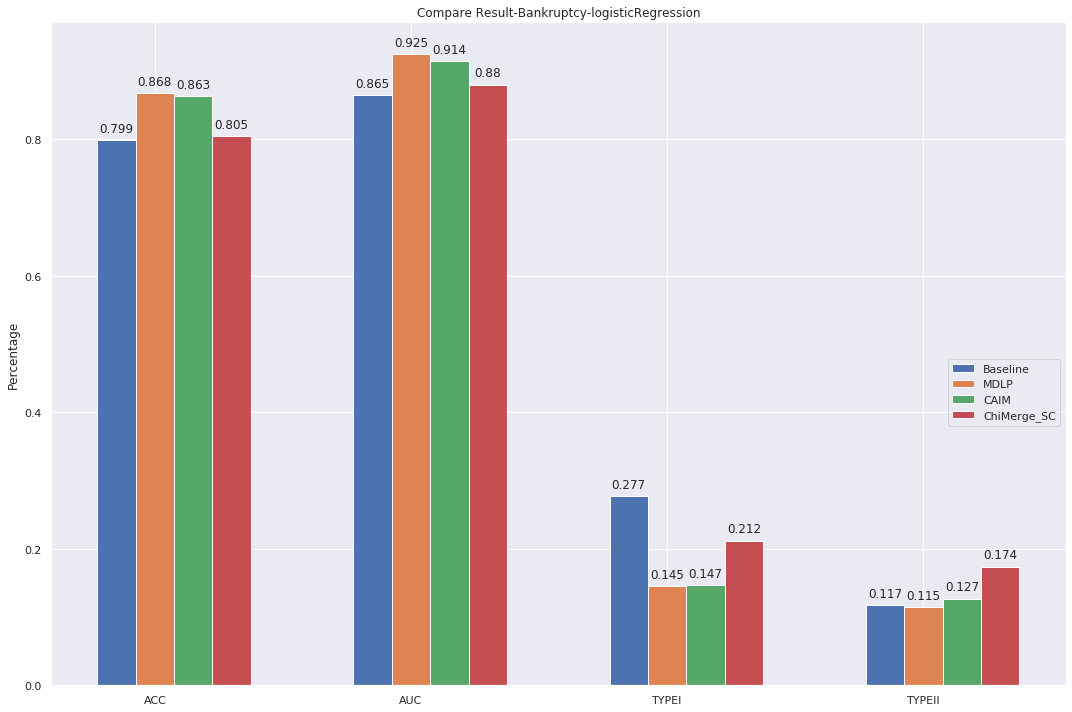

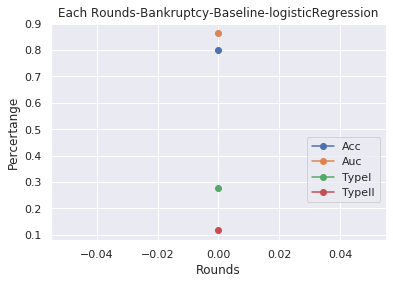

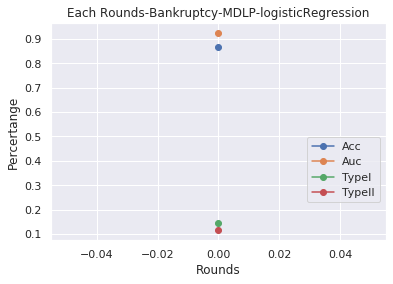

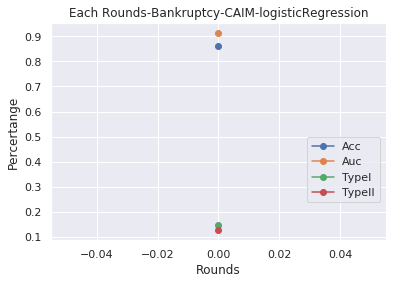

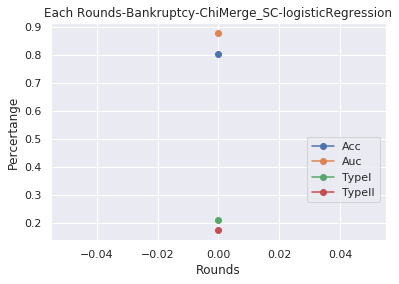

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.80 0.87   0.28    0.12          1.48
MDLP          0.87 0.92   0.14    0.11         49.11
CAIM          0.86 0.91   0.15    0.13        160.86
ChiMerge      0.81 0.88   0.21    0.17        546.58
Mean Accuracy: 0.8084848484848486
Mean Accuracy[0.8, 0.821969696969697, 0.821969696969697, 0.821969696969697, 0.7765151515151515]
Mean Auc: 0.8836344042753476
Mean Auc[0.8796614047128803, 0.9017096493769922, 0.8714917063651495, 0.9133754305396096, 0.8519338303821062]
Mean TypeII: 0.16600735645605674
Mean TypeII[0.1693548387096774, 0.14285714285714285, 0.1984732824427481, 0.16417910447761194, 0.15517241379310345]
Mean TypeI: 0.21221527250217828
Mean TypeI[0.22695035460992907, 0.20689655172413793, 0.15789473684210525, 0.19230769230769232, 0.27702702702702703]


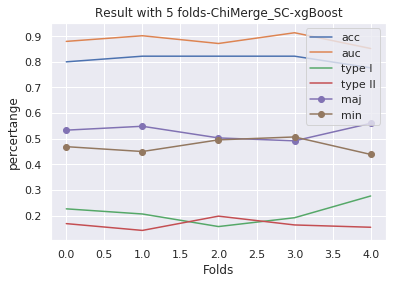

Compare Result-Bankruptcy-xgBoost


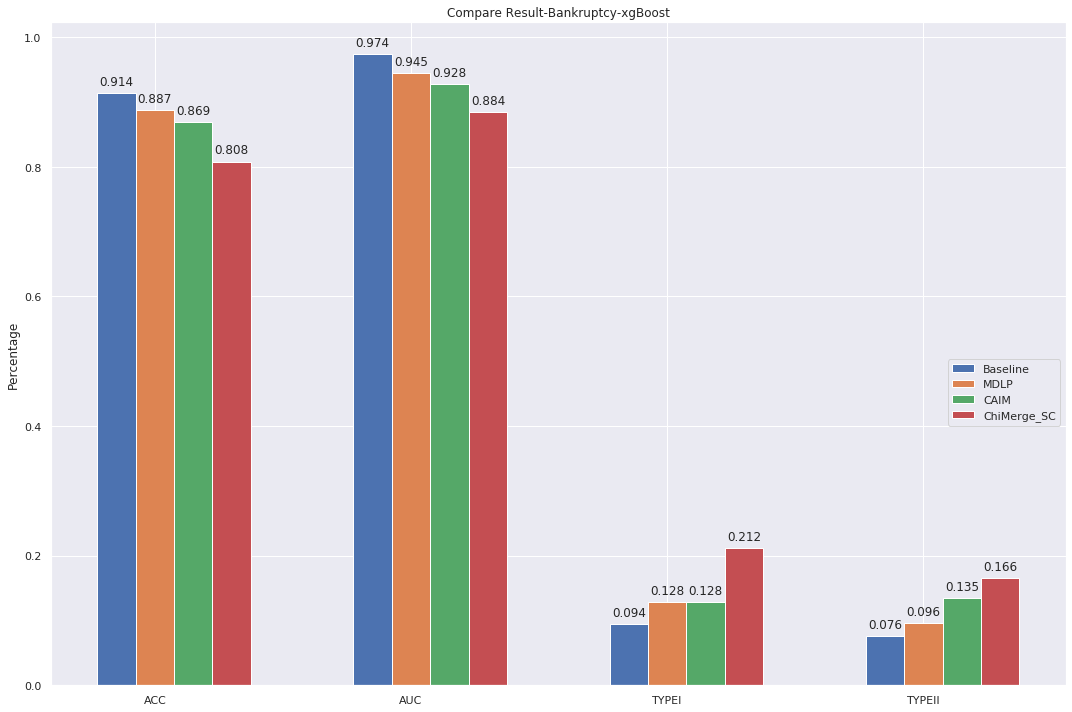

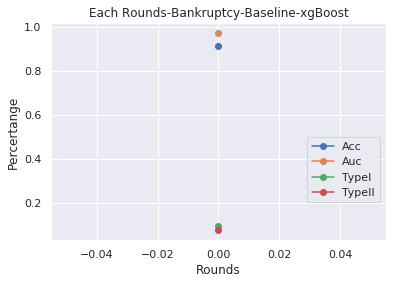

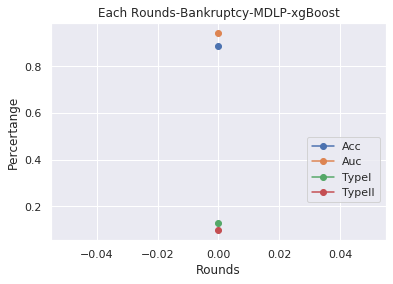

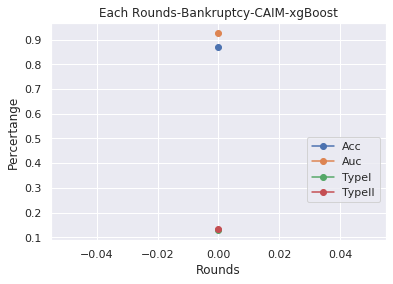

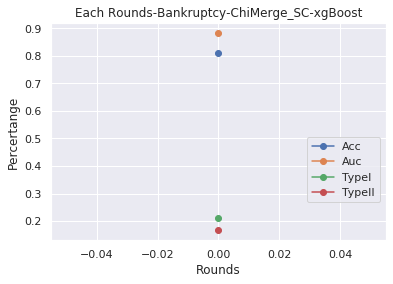

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.91 0.97   0.09    0.08          2.84
MDLP          0.89 0.94   0.13    0.10         47.19
CAIM          0.87 0.93   0.13    0.14        159.44
ChiMerge      0.81 0.88   0.21    0.17        571.03
Mean Accuracy: 0.8183104631217839
Mean Accuracy[0.8301886792452831, 0.7462121212121212, 0.8143939393939394, 0.8484848484848485, 0.8522727272727273]
Mean Auc: 0.8749087302753178
Mean Auc[0.8781349749202007, 0.821213338690237, 0.8906617689261322, 0.8784504483385103, 0.9060831205015092]
Mean TypeII: 0.1597534388572774
Mean TypeII[0.15503875968992248, 0.17557251908396945, 0.18796992481203006, 0.21238938053097345, 0.06779661016949153]
Mean TypeI: 0.2032291471950233
Mean TypeI[0.18382352941176472, 0.3308270676691729, 0.183206106870229, 0.10596026490066225, 0.21232876712328766]


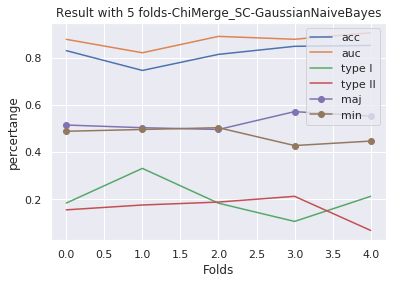

Compare Result-Bankruptcy-GaussianNaiveBayes


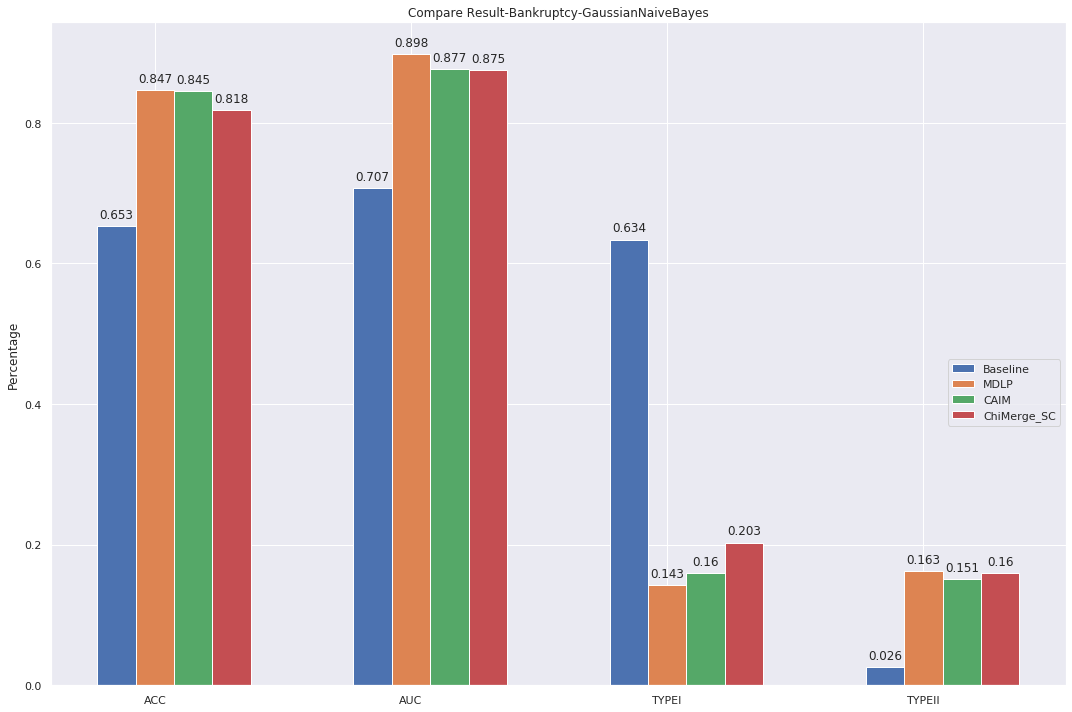

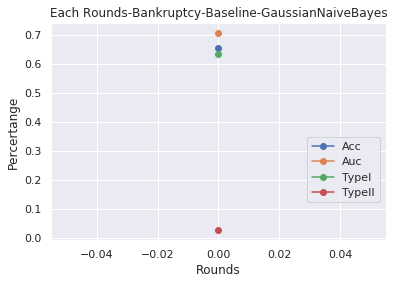

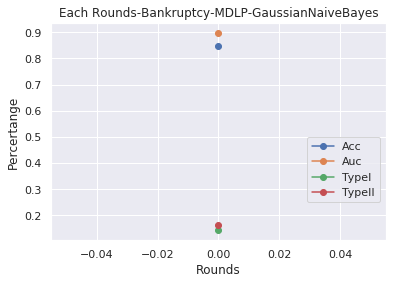

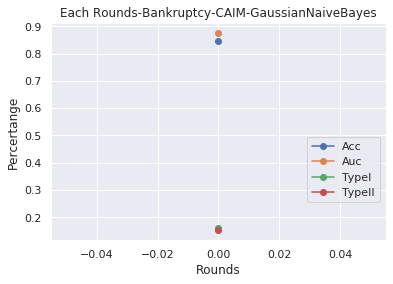

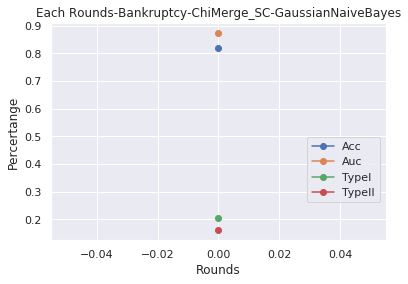

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.65 0.71   0.63    0.03          0.56
MDLP          0.85 0.90   0.14    0.16         44.83
CAIM          0.84 0.88   0.16    0.15        161.78
ChiMerge      0.82 0.87   0.20    0.16        591.58
Mean Accuracy: 0.6821297884505432
Mean Accuracy[0.5886792452830188, 0.7007575757575758, 0.6212121212121212, 0.6742424242424242, 0.8257575757575758]
Mean Auc: 0.6814865026278071
Mean Auc[0.5915954415954416, 0.6923611111111111, 0.6234759604324822, 0.6758064516129033, 0.8241935483870968]
Mean TypeII: 0.32124542124542127
Mean TypeII[0.25384615384615383, 0.4, 0.4523809523809524, 0.29838709677419356, 0.20161290322580644]
Mean TypeI: 0.3179669887278583
Mean TypeI[0.562962962962963, 0.2152777777777778, 0.3115942028985507, 0.35, 0.15]


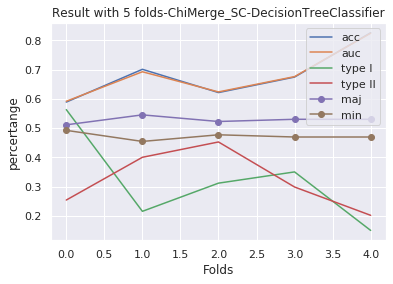

Compare Result-Bankruptcy-DecisionTreeClassifier


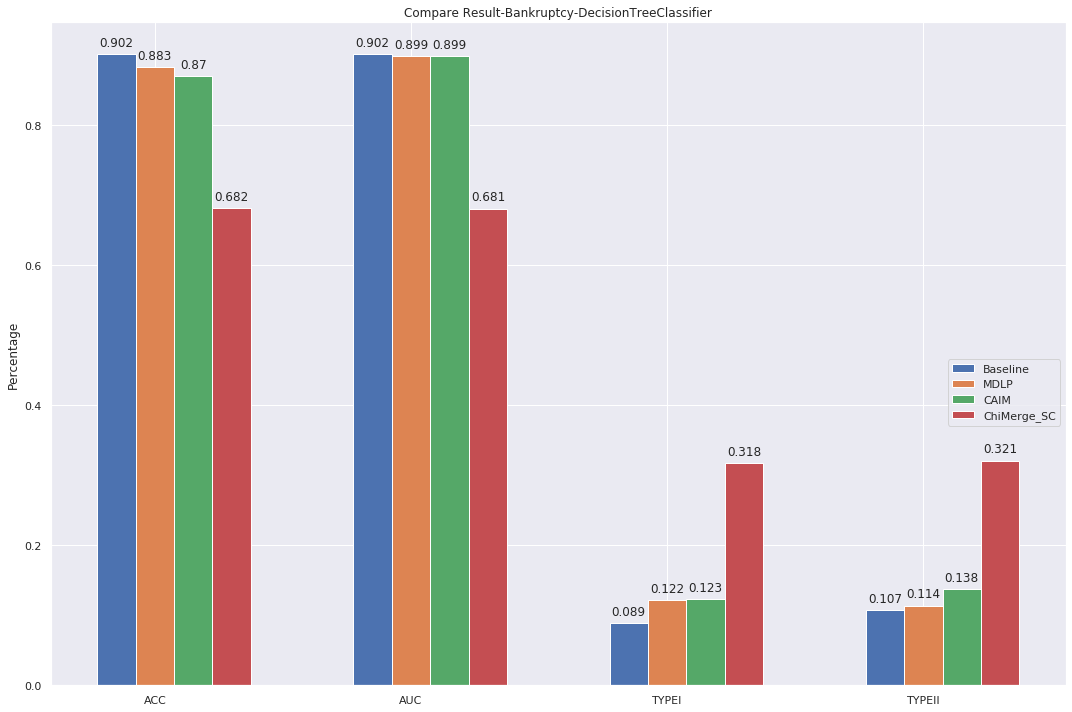

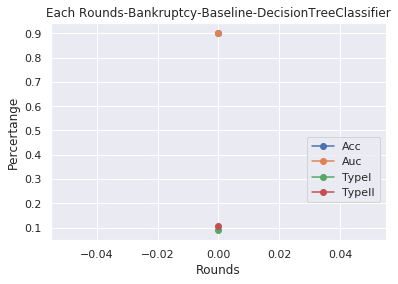

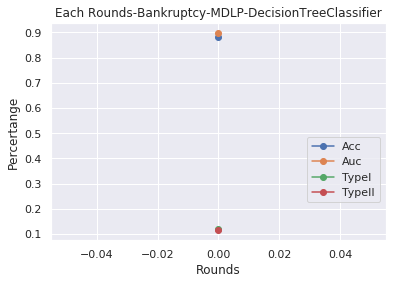

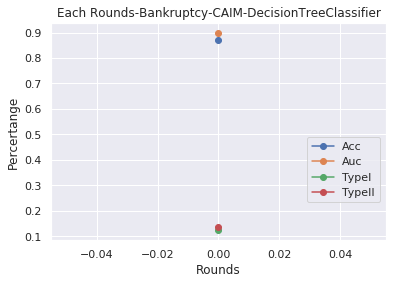

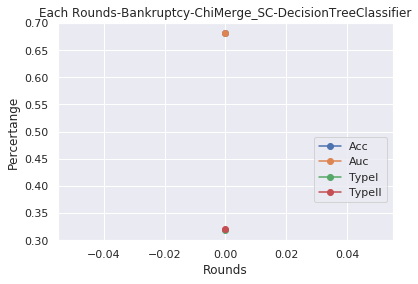

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.90 0.90   0.09    0.11          1.01
MDLP          0.88 0.90   0.12    0.11         48.52
CAIM          0.87 0.90   0.12    0.14        160.43
ChiMerge      0.68 0.68   0.32    0.32        592.97


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.7782189822755861
Mean Accuracy[0.7509433962264151, 0.7765151515151515, 0.7651515151515151, 0.75, 0.8484848484848485]
Mean Auc: 0.8551997364383859
Mean Auc[0.8404819554940621, 0.8614676258992806, 0.8493878958560837, 0.8277803308823529, 0.8968808740601504]
Mean TypeII: 0.25428009144608965
Mean TypeII[0.2796610169491525, 0.2446043165467626, 0.2047244094488189, 0.328125, 0.21428571428571427]
Mean TypeI: 0.1937994529352271
Mean TypeI[0.22448979591836735, 0.2, 0.26277372262773724, 0.17647058823529413, 0.10526315789473684]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


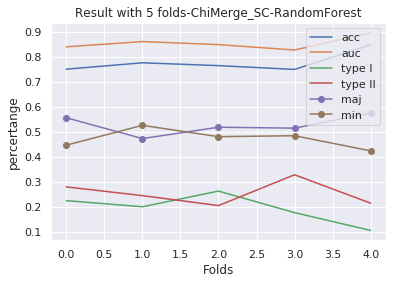

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.8251315037164094
Mean Accuracy[0.8264150943396227, 0.8636363636363636, 0.7992424242424242, 0.8409090909090909, 0.7954545454545454]
Mean Auc: 0.8810991554189709
Mean Auc[0.8780779753761969, 0.9029377880184332, 0.8579493087557604, 0.9097980032505225, 0.856732701693942]
Mean TypeII: 0.15167033283744663
Mean TypeII[0.1937984496124031, 0.12903225806451613, 0.25, 0.0847457627118644, 0.10077519379844961]
Mean TypeI: 0.19545871012027335
Mean TypeI[0.15441176470588236, 0.14285714285714285, 0.15714285714285714, 0.2191780821917808, 0.3037037037037037]
Compare Result-Bankruptcy-RandomForest


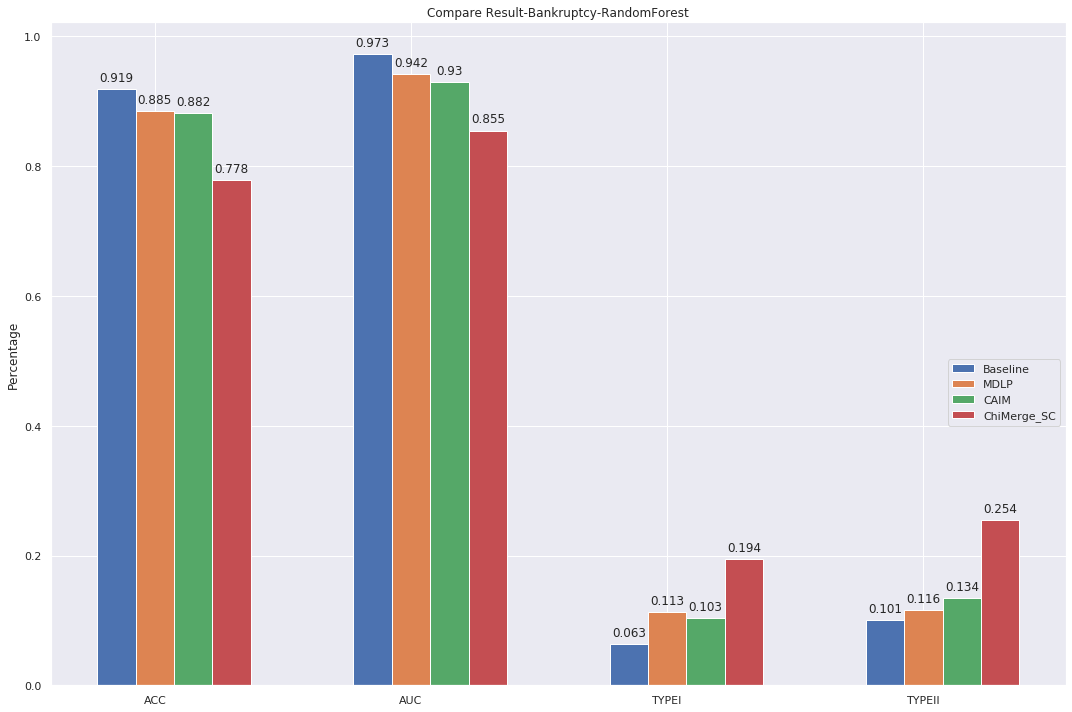

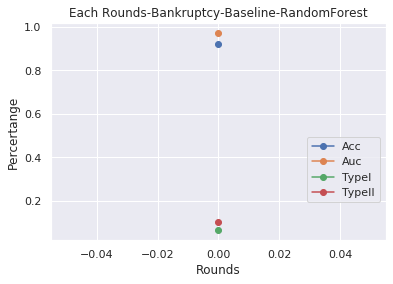

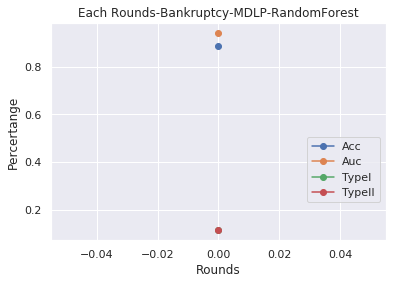

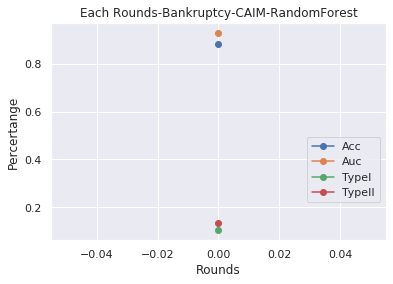

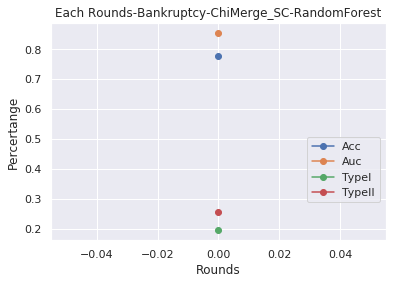

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.92 0.97   0.06    0.10          2.17
MDLP          0.88 0.94   0.11    0.12         49.01
CAIM          0.88 0.93   0.10    0.13        156.76
ChiMerge      0.78 0.86   0.19    0.25        597.94


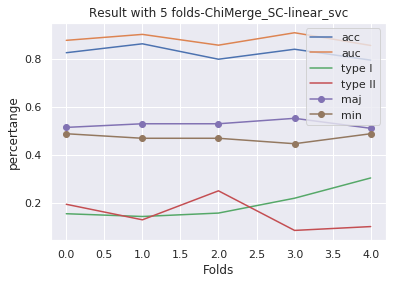

Compare Result-Bankruptcy-linear_svc


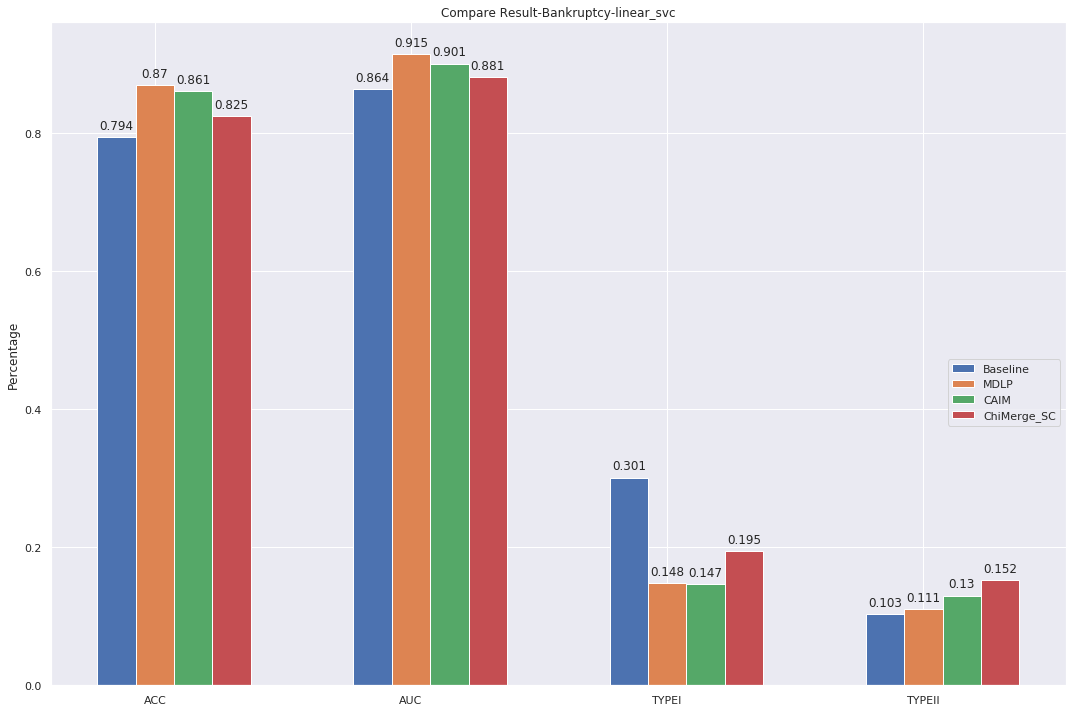

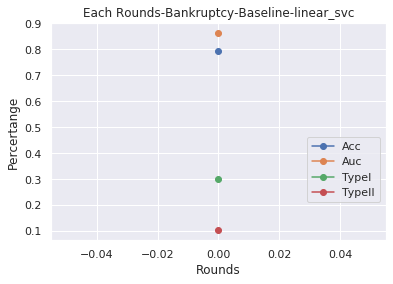

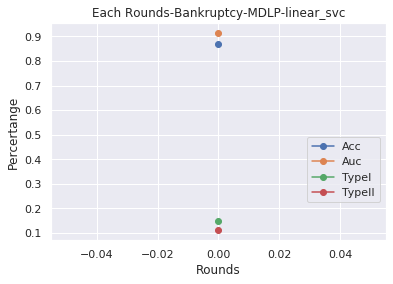

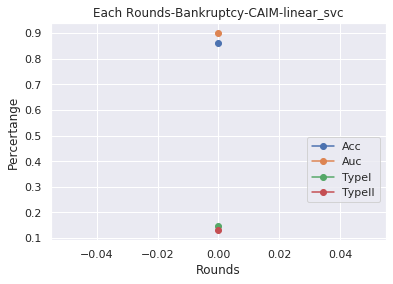

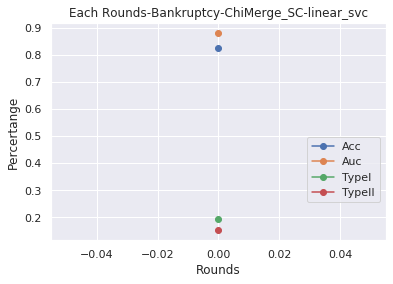

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.79 0.86   0.30    0.10          5.42
MDLP          0.87 0.92   0.15    0.11         46.64
CAIM          0.86 0.90   0.15    0.13        154.70
ChiMerge      0.83 0.88   0.20    0.15        600.69


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.6214694110920524
Mean Accuracy[0.660377358490566, 0.6022727272727273, 0.6212121212121212, 0.6174242424242424, 0.6060606060606061]
Mean Auc: 0.8347008930166094
Mean Auc[0.8945483945483945, 0.8635760825693363, 0.8639233241505969, 0.8282834101382488, 0.7231732536764707]
Mean TypeII: 0.7834081057121478
Mean TypeII[0.717948717948718, 0.8455284552845529, 0.7424242424242424, 0.8064516129032258, 0.8046875]
Mean TypeI: 0.015456010518588742
Mean TypeI[0.04054054054054054, 0.0070921985815602835, 0.015151515151515152, 0.007142857142857143, 0.007352941176470588]


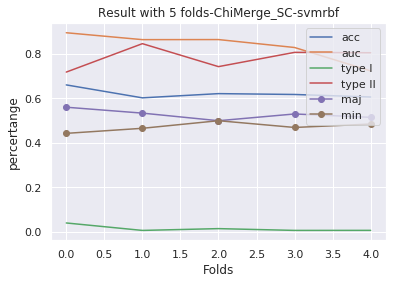

Compare Result-Bankruptcy-svmrbf


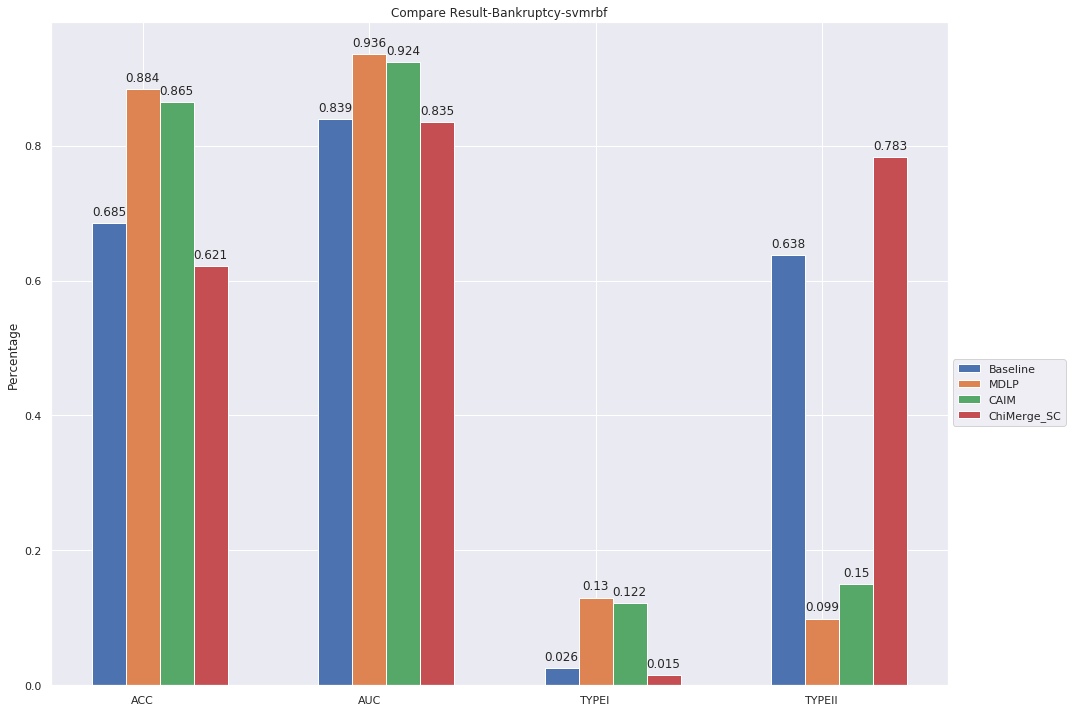

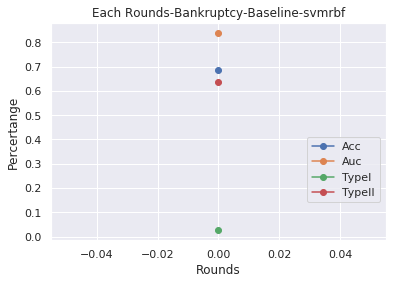

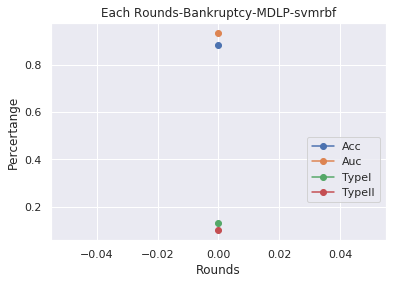

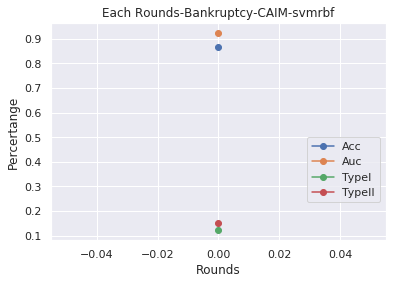

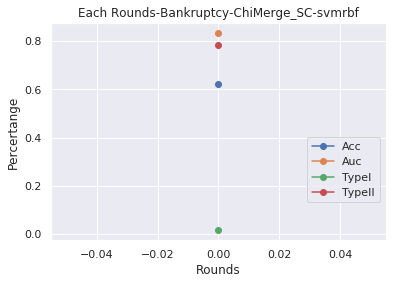

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.69 0.84   0.03    0.64          3.72
MDLP          0.88 0.94   0.13    0.10         45.23
CAIM          0.87 0.92   0.12    0.15        157.48
ChiMerge      0.62 0.83   0.02    0.78        603.19


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.7736735277301315
Mean Accuracy[0.7509433962264151, 0.7840909090909091, 0.7727272727272727, 0.7916666666666666, 0.7689393939393939]
Mean Auc: 0.8559276136117215
Mean Auc[0.8343023255813954, 0.8556813609977585, 0.8556985294117647, 0.8527769784172663, 0.8811788736504231]
Mean TypeII: 0.1651069608873461
Mean TypeII[0.17054263565891473, 0.14960629921259844, 0.203125, 0.224, 0.0782608695652174]
Mean TypeI: 0.2788279134891159
Mean TypeI[0.3235294117647059, 0.2773722627737226, 0.25, 0.19424460431654678, 0.348993288590604]


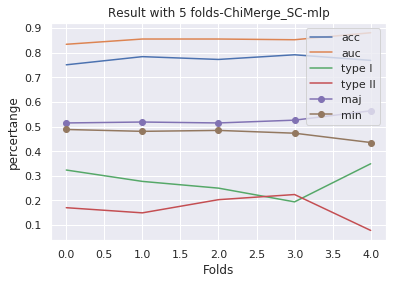

Compare Result-Bankruptcy-mlp


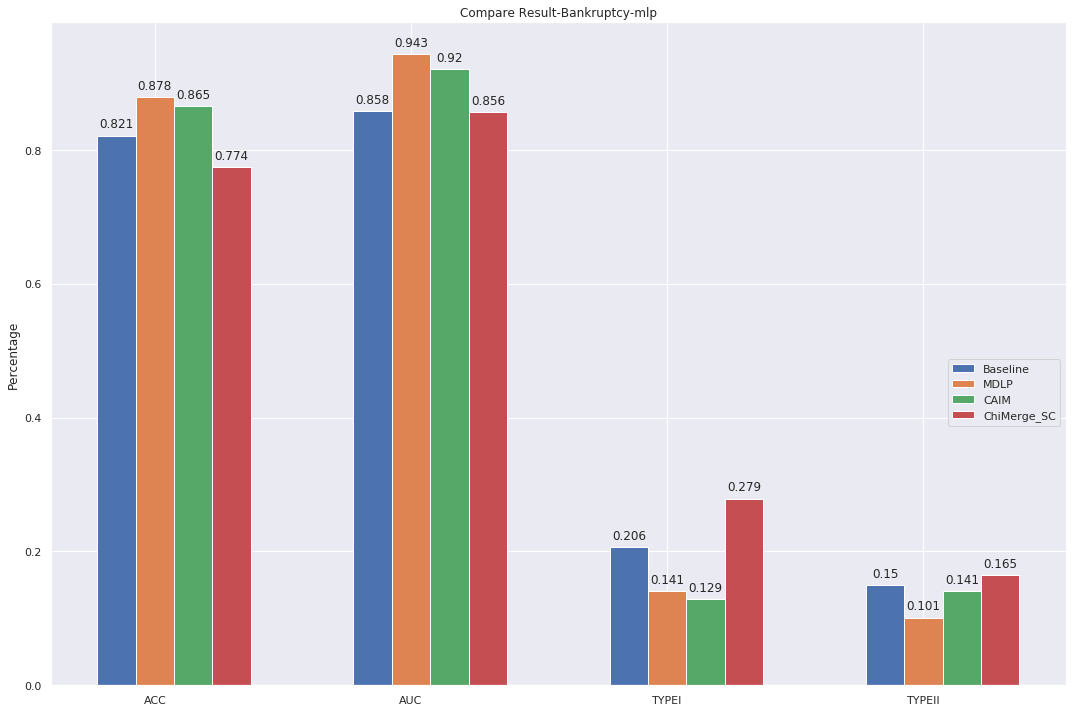

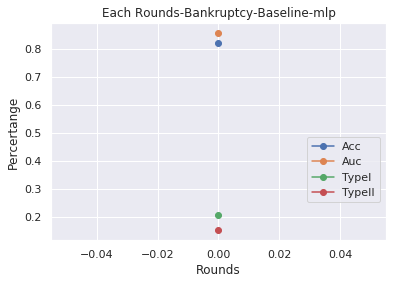

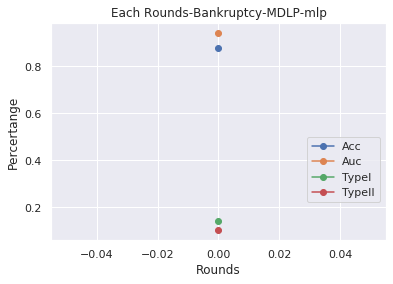

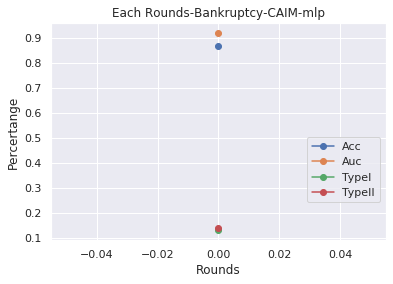

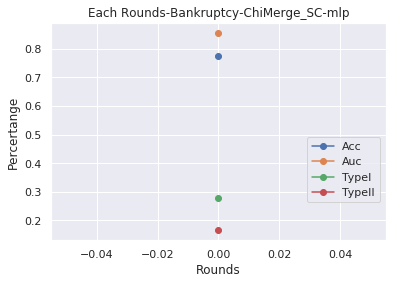

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.82 0.86   0.21    0.15         13.21
MDLP          0.88 0.94   0.14    0.10         58.39
CAIM          0.87 0.92   0.13    0.14        186.68
ChiMerge      0.77 0.86   0.28    0.17        560.70


In [ ]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()
GaussianNaiveBayes = GaussianNB()


##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

#DecisionTreeClassifier,logisticRegression,mlp,xgBoost
# classifier_list = [svmrbf,DecisionTreeClassifier,RandomForest,logisticRegression,mlp,xgBoost ]
# classifier_name_list = ['svmrbf','DecisionTreeClassifier','RandomForest','LogisticRegression','MLPClassifier','xgBoost' ]
def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
        
    classifier_result_list = []



    for idx,classifi in enumerate(classifier_list):

        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            runnung_time_list = []
            #Method Select

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'Baseline', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0)))
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIMD', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_SC', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_SC",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP','CAIM','ChiMerge'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{method}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,method=clf_name)
        pd.DataFrame(result_with_method).to_excel("resultsexcel/"+file_name)
        
        
        # Thread Unlock
        lock.release()
    


t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
t6 = Thread(target=run10times,args=(mlp,"mlp"))
t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))
t8 = Thread(target=run10times,args=(GaussianNaiveBayes,"GaussianNaiveBayes"))


thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t0]
#thread_list = [t4]

#程式開始
for item in thread_list:
    item.start()
print("\n程式開始")


#程式結束
for item in thread_list:
    item.join()
print("\n程式結束")
    


#############################################################################YEE

## Record Result

title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
with pd.ExcelWriter('output.xlsx') as writer:  # doctest: +SKIP
        df1.to_excel(writer, sheet_name='Sheet_name_1')
        df2.to_excel(writer, sheet_name='Sheet_name_2')

file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
file_name = "result_10times_baseline_{file_timeA}.xlsx".format(file_timeA = file_time)
pd.DataFrame(result_10times_baseline).to_excel(file_name, header=False, index=False)

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))

In [ ]:

#ResultEachMethodLineChart(result_10times_ChiMerge_RG,"ChiMerge_RG",data_name,clf_name)